## Basic Optimization

In this page we shall demosntrate how to use Scipy's optimization package.


Lets optimize $f(x) = \exp{(x-2)^2}$

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as mp
import scipy as sp
from scipy import optimize
from scipy import fftpack
import skopt as opt

def f(y):
    return -np.exp(-(y-2)**2)

result = optimize.minimize_scalar(f)

print(result)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -1.0
       x: 1.9999999955459995
     nit: 6
    nfev: 10



### Using minimize function
We can also use Python's minimize or maximize function (with the ''key'' option) to optimize the function!

You can also pass more arguments.

Why to use the "optimize" function then?

**My answer**

The optimize functions in SciPy use advanced numerical algorithms to find minima (or maxima) in continuous domains efficiently and accurately. Unlike Python’s built-in min or max, they don’t rely on discrete sampling and can handle bounds, constraints, and derivative information. In short, optimize is used for precise, robust optimization beyond simple value comparisons.

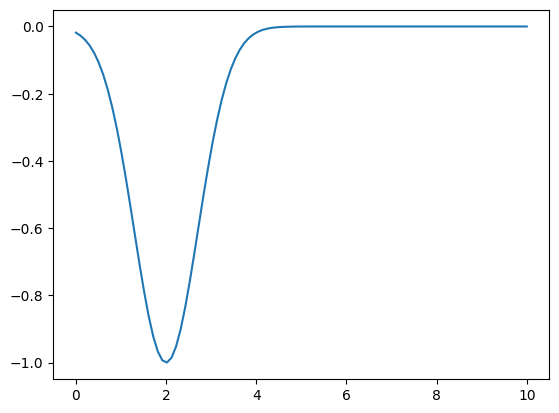

2.0202020202020203


In [3]:
y = np.linspace(0,10,100)
mp.plot(y,-np.exp(-(y-2)**2)); mp.show()
#print(max(y, key=lambda x: np.sinc(x-5)))

print(min(y, key=lambda x: -np.exp(-(x-2)**2)))

### Rosenbrock function

Now we optimize the infamous Rosenbrock function.

$f(x,y) = 0.5*(1-x)^2 + (y - x^2)^2$

In [4]:
def f(x):   # The rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
optimize.minimize(f, [0,-1], method="CG")

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.2743806081839638e-11
       x: [ 1.000e+00  1.000e+00]
     nit: 8
     jac: [-2.100e-07  2.518e-06]
    nfev: 48
    njev: 16

What happens if we change the seed to something very far from the solution point?

**My answer**

If you start far from the true minimum, the optimizer may take much longer to converge or even fail to find the global minimum. The Rosenbrock function has a narrow, curved valley that makes optimization difficult for many algorithms, especially when starting far away. As a result, the method might get stuck, converge very slowly

In [5]:
optimize.minimize(f, [200,-110], method="CG")

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.988484547652788e-10
       x: [ 1.000e+00  1.000e+00]
     nit: 19
     jac: [ 6.786e-06  8.505e-06]
    nfev: 158
    njev: 52

**Constrained Optimization**

In this you need to give the constraints as well.

For example: $f(x) = 2xy + 2x - x^2 - 2 y^2$.

Constraints are as follows:

$x^3−y = 0$

$y−1 \geq 0$

In [6]:
def func(x, sign=1.0):
    """ Objective function """
    return sign*(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

cons = ({'type': 'eq',
          'fun' : lambda x: np.array([x[0]**3 - x[1]])},
        {'type': 'ineq',
          'fun' : lambda x: np.array([x[1] - 1])})

res = optimize.minimize(func, [-1.0,1.0], args=(-1.0,),
                method='SLSQP', options={'disp': True})
print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.999999999999997
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
[1.99999994 0.99999995]


In [7]:
res = optimize.minimize(func, [-1.0,1.0], args=(-1.0,),
                constraints=cons, method='BFGS', options={'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: -2.000000
         Iterations: 6
         Function evaluations: 21
         Gradient evaluations: 7
[2.00000009 1.00000005]


/tmp/ipython-input-2128810766.py:1: RuntimeWarning: Method BFGS cannot handle constraints.
  res = optimize.minimize(func, [-1.0,1.0], args=(-1.0,),


## COMPRESSIVE SENSING

Now lets discuss about compressive sensing. Lets assume that we have some signal recorded (following Nyquist rate); lets call it $x$. Its size is $N$.

In the following signal we are using 500 samples and two sinusoids. You can note that one of them takes 10 samples per cycle; hence there are 50 cycles. So Nyquist will want us to have at least 100 samples in order to be able to know whats in the signal!

However if we look the signal through DCT then there are just two samples. Mark that we are using DCT and not FFT; because then we dont have to deal with complex numbers!



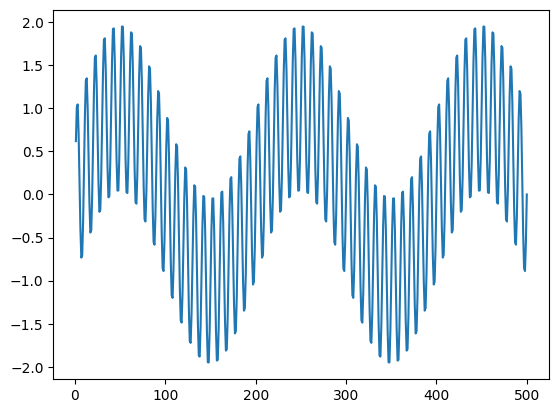

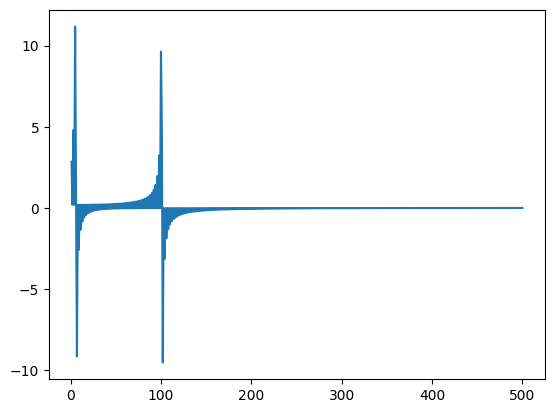

([<matplotlib.lines.Line2D at 0x78aec9a66450>], None)

In [8]:
n = np.linspace(1,500,500)

#two harmonics signal
xx = np.sin(2*np.pi*n/10) + np.sin(2*np.pi*n/200)  #+ np.sin(2*np.pi*n/50)
mp.plot(n,xx), mp.show()
mp.plot(n,fftpack.dct(xx, norm='ortho')), mp.show()

**Sparse Sampling** \\
Lets assume that we only consider $n$ of this ($n \ll N$).

For this lets define a sparsifying vector sp which has only $n$ 1's and rest zeros placed in random places.

So sparsed data $xp = xx*sp$.

The trick is that these $n$ samples are randomly taken.

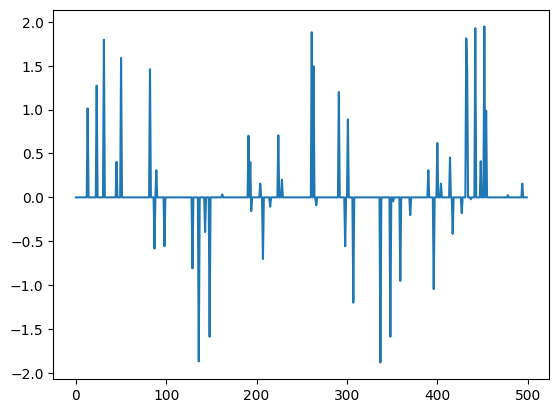

([<matplotlib.lines.Line2D at 0x78aec9bba210>], None)

In [9]:
N = len(xx) #length of actual N
n = 50 #number of nonzero samples in our sparse signal
sp = np.array([1] * n + [0] * (N-n)) #n 1's and (N-n) 0's
np.random.shuffle(sp)

xp = xx*sp
mp.plot(xp), mp.show()

### Using Optimization
The trick of compressive sensing is that we try to use optimization in order to know the unknown from what is known!

So let us think what we know.

1- We know $xp$  the random-subNyquist-sampled signal and $sp$.

2- We know that the signal is sparse in DCT domain.

So lets try to look into the DCT domain. Lets assume that the DCT of the signal is $XX$. So IDCT of it should give us $xp$ back.

Lets define an optimization problem to do this.

What are the DCT samples that will give rise to a time domain signal which has the values of $xp$ at $sp$ time-indices. \\
We start with an intial estimate $XX$ which we will update in each iteration. \\
The cost function will be Euclidean distance between $xp$ and IDCT of $XX$.

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000001
         Iterations: 3
         Function evaluations: 33078
         Gradient evaluations: 66


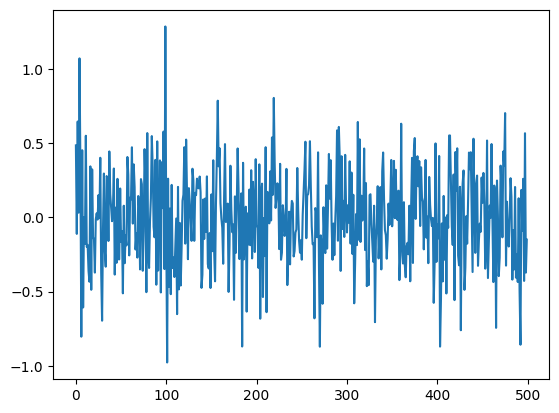

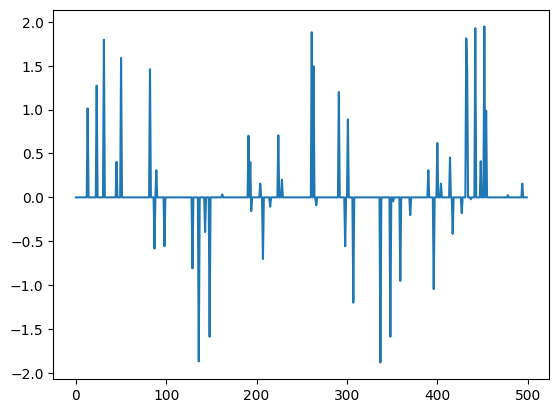

([<matplotlib.lines.Line2D at 0x78aec9b33a10>], None)

In [10]:

XX = np.random.rand(N)
def cost_cs(XX):   #given the measured xp and a generic X find the L1 norm
    xd = fftpack.idct(XX, norm='ortho') #derived x from X
    xdn = xd*sp
    return np.linalg.norm((xdn - xp), ord=2)

seed = np.zeros(N)

CS = optimize.minimize(cost_cs, seed, options={'disp': True})

xrecon = fftpack.idct(CS.x, norm='ortho')
mp.plot(CS.x), mp.show()
mp.plot(xrecon), mp.show()

### Redfining the Optimization
Hmmmm. Enen though the optimization has not finished doing its job if we look at the result we seem to have achieved what we asked for!

The reconstructed signal $xrecon$ looks exactly like $xp$. So we did achieve what we wanted (theoritically speaking) but we want more.

What else can we do?

Lets add a condition that we want to optimize $||xrecon - xp ||$ but we also want to keep XX sparse, i.e. the $L0$ norm of $XX$ should be less than $n$.

Iteration limit reached    (Exit mode 9)
            Current function value: 9.209304355253381e-07
            Iterations: 100
            Function evaluations: 51408
            Gradient evaluations: 101


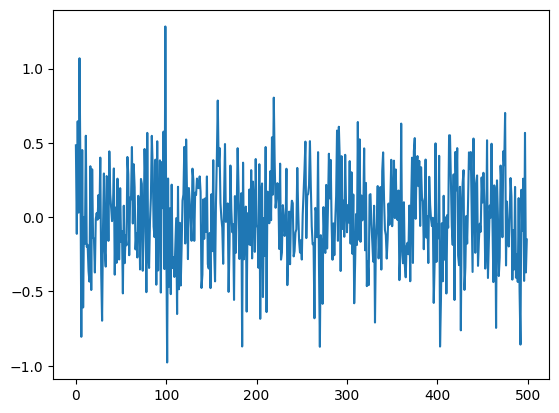

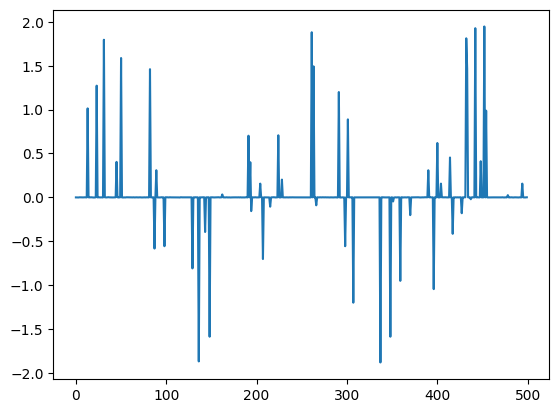

([<matplotlib.lines.Line2D at 0x78aebff8d970>], None)

In [11]:
XX = np.random.rand(N)
def cost_cs(XX):   #given the measured xp and a generic X find the L1 norm
    xd = fftpack.idct(XX, norm='ortho') #derived x from X
    xdn = xd*sp
    return np.linalg.norm((xdn - xp), ord=2)

cons = ({'type': 'ineq',
          'fun' : lambda XX: n - np.linalg.norm(XX,ord=0)})

#seed = np.random.rand(N)
seed = np.zeros(N)

CS = optimize.minimize(cost_cs, seed, constraints=cons, options={'disp': True})

xrecon = fftpack.idct(CS.x, norm='ortho')
mp.plot(CS.x), mp.show()
mp.plot(xrecon), mp.show()

### Re-redfining the Optimization: L1 Magic!!
Hmmmm. It seems its not working the way we want it to work. What else can we do?

It seems achieving $xrecon = xp$ is an easy task, because its sparse anyway.

So lets keep this as a condition (instead of making it the cost-function). And minimize $XX$. And let us use $L1$ norm here so as to keep the error under control. Remember that even though $L2$ norm is smooth, it has a square and blows up the error. So in wildly uknown problems like what we dealing with here, its better to use $L1$ norm.

In [12]:
XX = np.random.rand(N)
def cost_cs(XX):   #given the measured xp and a generic X find the L1 norm
    return np.linalg.norm(XX, ord=1)

cons = ({'type': 'eq',
          'fun' : lambda XX : np.linalg.norm(xp - fftpack.idct(XX, norm='ortho')*sp, ord = 2)})

seed = np.random.rand(N)
#seed = np.zeros(N)

CS = optimize.minimize(cost_cs, seed, constraints=cons, options={'disp': True})

Iteration limit reached    (Exit mode 9)
            Current function value: 64.14990667096397
            Iterations: 100
            Function evaluations: 50908
            Gradient evaluations: 101


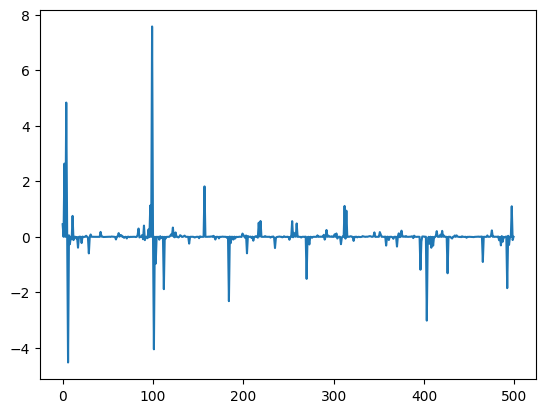

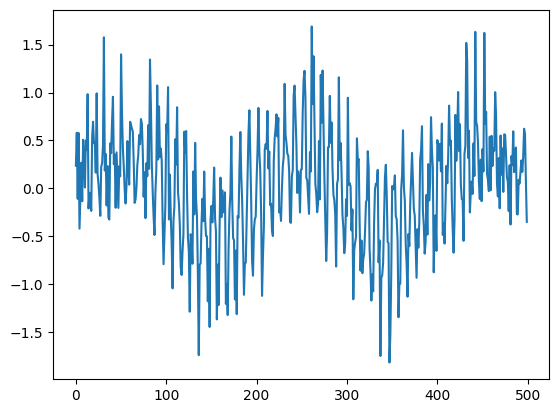

([<matplotlib.lines.Line2D at 0x78aebfe62e10>], None)

In [13]:
xrecon = fftpack.idct(CS.x, norm='ortho')
mp.plot(CS.x), mp.show()
mp.plot(xrecon), mp.show()

### Conclusion
Unfortunately the optimization process did not end. We need more iteration. However, we seem to have got something which looks pretty much like the signal we have started with. It is noisy but it is encouraging given the fact that we have got only half the number of samples as Nyquist would have wanted.

This is the starting of Compressive Sensing (CS). We have learnt two things.

1- It is easy to cheat Nyquist if the signal is sparse in some other linearly transferable domain. 2- Redefining the optimization problem can help us achieve magical results.

The hard-core CS involvs more interesting objective functions and constraints to achieve even more interesting magical results.

# Histograms

## Sentinel 2 data

In [15]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 64.4 MB/s eta 0:00:00


In [16]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

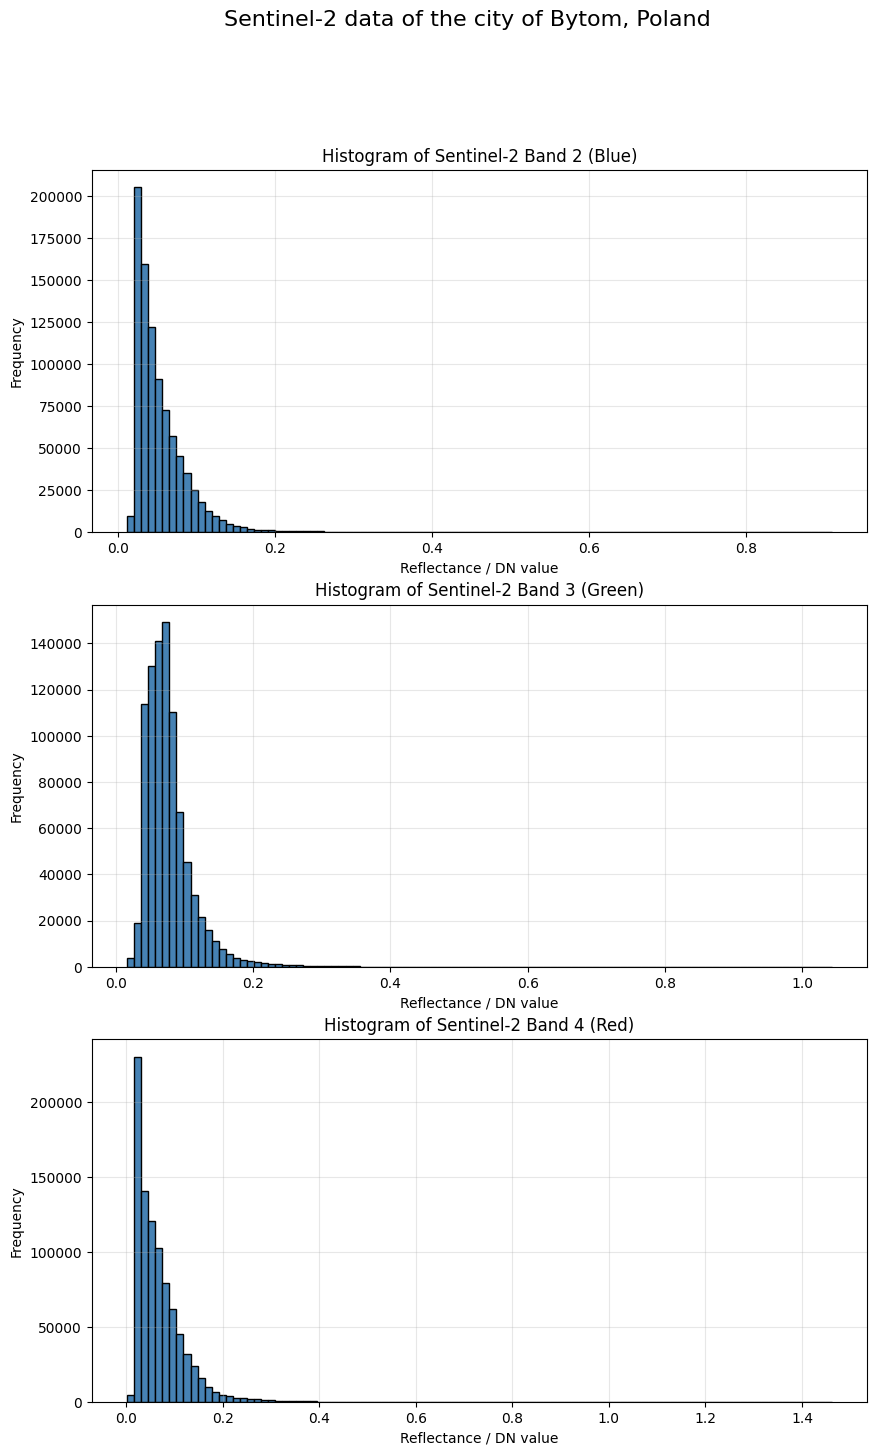

In [19]:
band_path_bytom = {
    'B02': 'bytom/bytom_B02.tiff',
    'B03': 'bytom/bytom_B03.tiff',
    'B04': 'bytom/bytom_B04.tiff'
}


with rasterio.open(band_path_bytom['B02']) as src:
    band2 = src.read(1)
    band2 = band2.astype(float)
    band2 = np.where(band2 == 0, np.nan, band2)

with rasterio.open(band_path_bytom['B03']) as src:
    band3 = src.read(1)
    band3 = band3.astype(float)
    band3 = np.where(band3 == 0, np.nan, band3)

with rasterio.open(band_path_bytom['B04']) as src:
    band4 = src.read(1)
    band4 = band4.astype(float)
    band4 = np.where(band4 == 0, np.nan, band4)


plt.figure(figsize=(10, 16))

plt.subplot(3,1,1)
plt.hist(band2[~np.isnan(band2)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-2 Band 2 (Blue)")
plt.xlabel("Reflectance / DN value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(3,1,2)
plt.hist(band3[~np.isnan(band3)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-2 Band 3 (Green)")
plt.xlabel("Reflectance / DN value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(3,1,3)
plt.hist(band4[~np.isnan(band4)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-2 Band 4 (Red)")
plt.xlabel("Reflectance / DN value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.suptitle("Sentinel-2 data of the city of Bytom, Poland", fontsize=16)
plt.show()

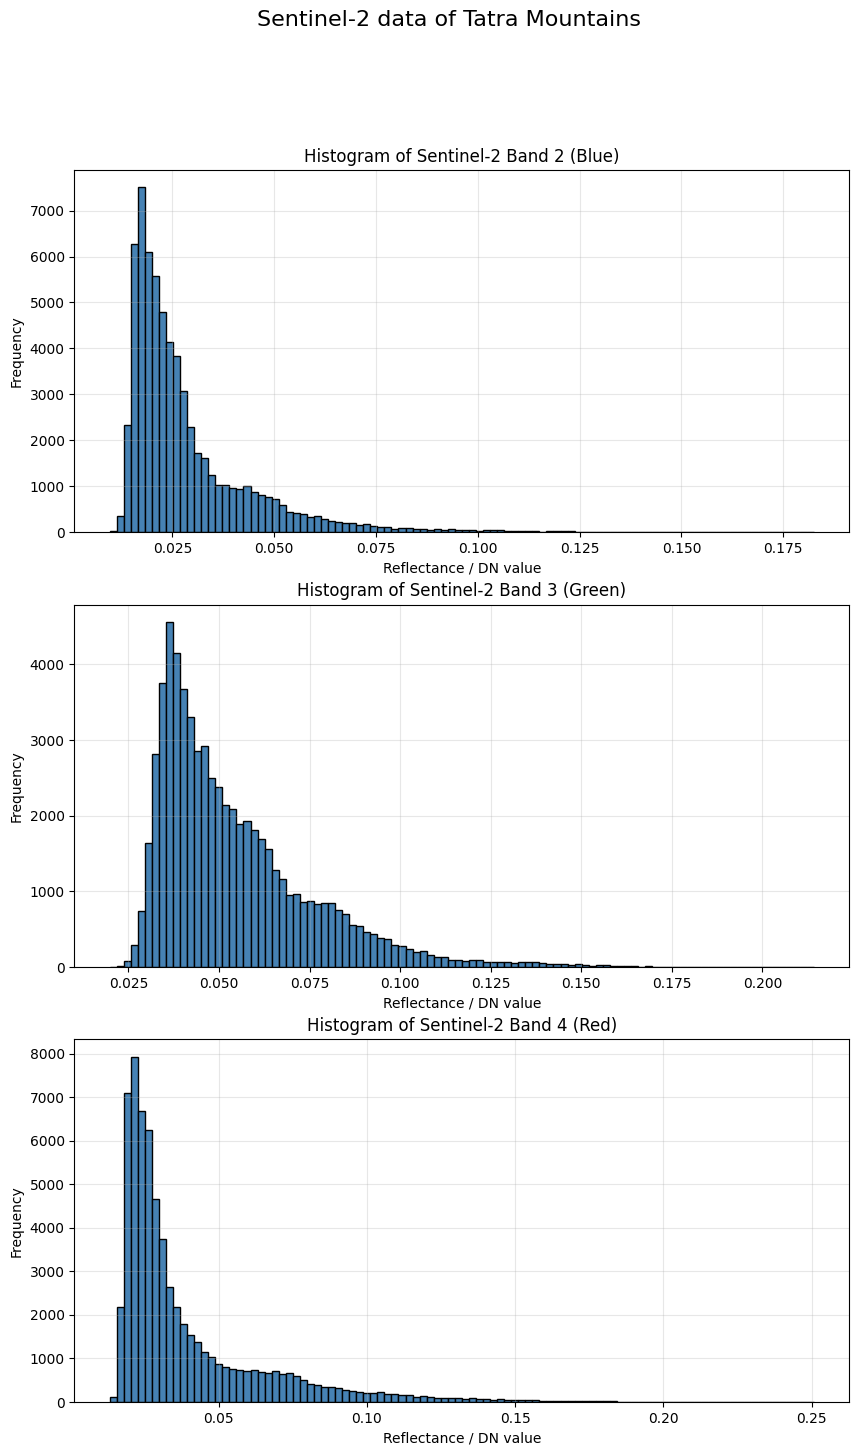

In [20]:
band_path_tatry = {
    'B02': 'tatry/tatry_B02.tiff',
    'B03': 'tatry/tatry_B03.tiff',
    'B04': 'tatry/tatry_B04.tiff'
}


# Open the band
with rasterio.open(band_path_tatry['B02']) as src:
    band2 = src.read(1)
    band2 = band2.astype(float)
    band2 = np.where(band2 == 0, np.nan, band2)

with rasterio.open(band_path_tatry['B03']) as src:
    band3 = src.read(1)
    band3 = band3.astype(float)
    band3 = np.where(band3 == 0, np.nan, band3)

with rasterio.open(band_path_tatry['B04']) as src:
    band4 = src.read(1)
    band4 = band4.astype(float)
    band4 = np.where(band4 == 0, np.nan, band4)

# Plot histogram
plt.figure(figsize=(10, 16))

plt.subplot(3,1,1)
plt.hist(band2[~np.isnan(band2)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-2 Band 2 (Blue)")
plt.xlabel("Reflectance / DN value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(3,1,2)
plt.hist(band3[~np.isnan(band3)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-2 Band 3 (Green)")
plt.xlabel("Reflectance / DN value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(3,1,3)
plt.hist(band4[~np.isnan(band4)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-2 Band 4 (Red)")
plt.xlabel("Reflectance / DN value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.suptitle("Sentinel-2 data of Tatra Mountains", fontsize=16)
plt.show()

## Conclusions

The histograms show clear spectral differences between the natural area (Tatra Mountains) and the urban area (Bytom). In the Tatra region, reflectance values are generally low and concentrated within a narrow range, indicating natural surfaces such as vegetation, soil, and rocks with limited spectral variability. In contrast, the Bytom area exhibits a wider range of reflectance values and higher overall brightness, typical of urban materials like concrete, roofs, and asphalt. These results highlight the higher spectral heterogeneity of built-up environments compared to natural landscapes.

**Answer for question 3**

Compressive sensing is useful while reconstructing image due to corrupted data. Also, because of the vast amount of satellite date, it can handle with the problem of overcollecting data (which is a solution for smaller, cheaper satellites without powerful onboard systems).

## Sentinel-1 data

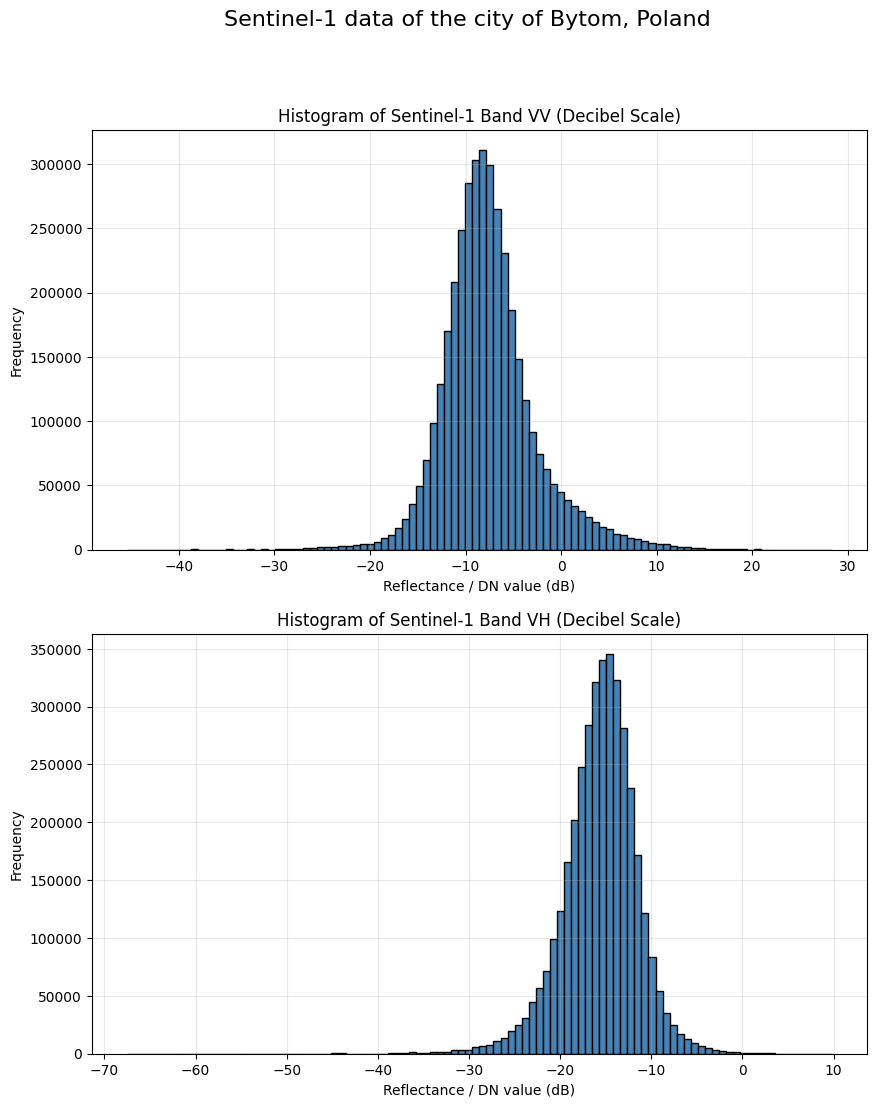

In [23]:
band_path_bytom_sar = {
    'VV': 'bytom/bytom_VV.tiff',
    'VH': 'bytom/bytom_VH.tiff'
}


with rasterio.open(band_path_bytom_sar['VV']) as src:
    band2 = src.read(1)
    band2 = band2.astype(float)
    band2 = np.where(band2 == 0, np.nan, band2)
    band2 = 10 * np.log10(band2)

with rasterio.open(band_path_bytom_sar['VH']) as src:
    band3 = src.read(1)
    band3 = band3.astype(float)
    band3 = np.where(band3 == 0, np.nan, band3)
    band3 = 10 * np.log10(band3)



plt.figure(figsize=(10, 12))

plt.subplot(2,1,1)
plt.hist(band2[~np.isnan(band2)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-1 Band VV (Decibel Scale)")
plt.xlabel("Reflectance / DN value (dB)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(2,1,2)
plt.hist(band3[~np.isnan(band3)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-1 Band VH (Decibel Scale)")
plt.xlabel("Reflectance / DN value (dB)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)


plt.suptitle("Sentinel-1 data of the city of Bytom, Poland", fontsize=16)
plt.show()

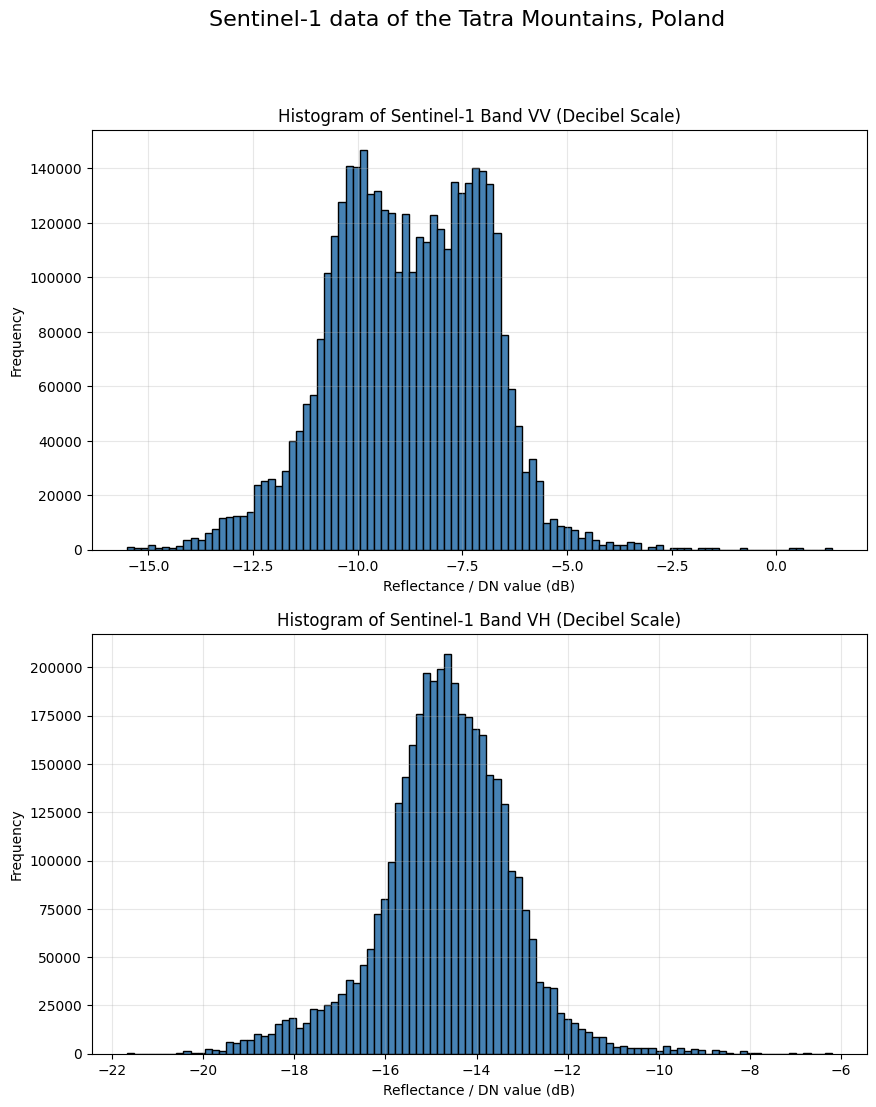

In [24]:
band_path_tatry_sar = {
    'VV': 'tatry/tatry_VV.tiff',
    'VH': 'tatry/tatry_VH.tiff'
}



with rasterio.open(band_path_tatry_sar['VV']) as src:
    band2 = src.read(1)
    band2 = band2.astype(float)
    band2 = np.where(band2 == 0, np.nan, band2)
    band2 = 10 * np.log10(band2)

with rasterio.open(band_path_tatry_sar['VH']) as src:
    band3 = src.read(1)
    band3 = band3.astype(float)
    band3 = np.where(band3 == 0, np.nan, band3)
    band3 = 10 * np.log10(band3)


plt.figure(figsize=(10, 12))

plt.subplot(2,1,1)
plt.hist(band2[~np.isnan(band2)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-1 Band VV (Decibel Scale)")
plt.xlabel("Reflectance / DN value (dB)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(2,1,2)
plt.hist(band3[~np.isnan(band3)].flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Sentinel-1 Band VH (Decibel Scale)")
plt.xlabel("Reflectance / DN value (dB)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)


plt.suptitle("Sentinel-1 data of the Tatra Mountains, Poland", fontsize=16)
plt.show()

## Conclusions

Similarly to the optical Sentinel-2 images, there is a clear reduction in the range of intensity values due to land surface development. No significant differences related to polarization configuration are observed, at least in terms of the interval width on the decibel scale. The intensity for VV polarization is generally higher.

# Stegenography

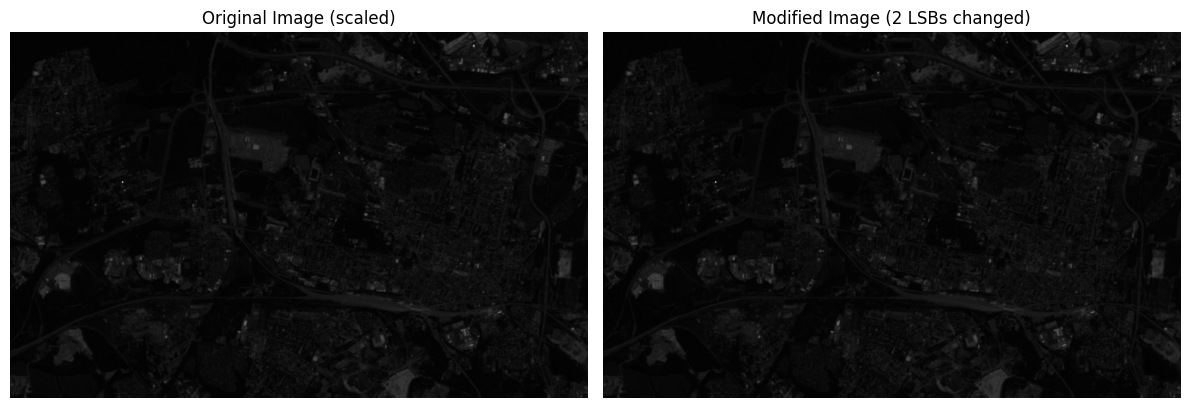

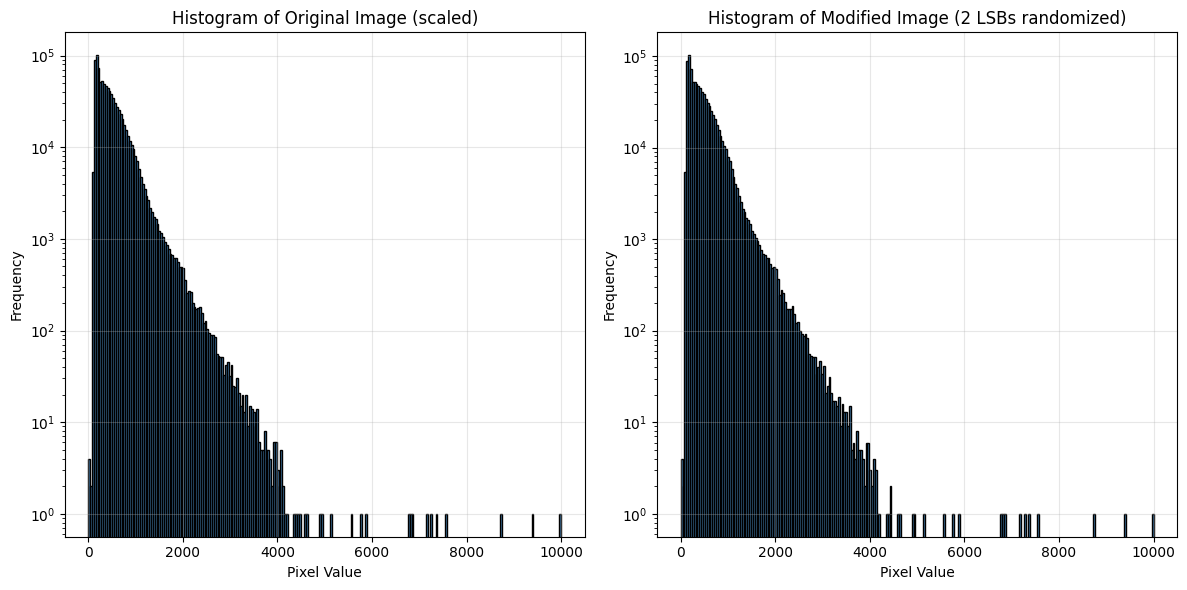

In [61]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

with rasterio.open(band_path_bytom['B04']) as src:
    original_image = src.read(1)


if np.issubdtype(original_image.dtype, np.floating):
    scaled = original_image * (10000 / original_image.max())
else:
    scaled = original_image

original_image = scaled.astype(np.uint16)

random_lsbs = np.random.randint(0, 4, size=original_image.shape, dtype=np.uint16)
mask = np.uint16(~np.uint16(0x03))

modified_image = (original_image & mask) | random_lsbs

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image (scaled)")
axes[0].axis('off')

axes[1].imshow(modified_image, cmap='gray')
axes[1].set_title("Modified Image (2 LSBs changed)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(original_image.flatten(), bins=256, color='steelblue', edgecolor='black', log=True)
plt.title("Histogram of Original Image (scaled)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(modified_image.flatten(), bins=256, color='steelblue', edgecolor='black', log=True)
plt.title("Histogram of Modified Image (2 LSBs randomized)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [64]:
print(f"Standard deviation of original image: {np.std(original_image)}")
print(f"Standard deviation of modified image: {np.std(modified_image)}")
print(f"Mean of original image: {np.mean(original_image)}")
print(f"Mean of modified image: {np.mean(modified_image)}")

Standard deviation of original image: 334.2313525504999
Standard deviation of modified image: 334.23363705327955
Mean of original image: 459.3829150289974
Mean of modified image: 459.38373777616806


## Conclusion

To the naked eye, the visual difference between the images is imperceptible, and the same applies to the histogram. Visually assessing the histograms, they have the same distribution of values. A slight difference can be noticed when calculating the standard deviation and mean of the image values. In the case of the manipulated image, these parameters are slightly higher. In the analyzed case, distinguishing the manipulated image from the original is not possible.